In [20]:
import cv2
import mediapipe as mp
import numpy as np

# ==== Load Model Age & Gender ====
face_proto = 'model/deploy.prototxt'
face_model = 'model/res10_300x300_ssd_iter_140000.caffemodel'
age_proto = 'model/age_deploy.prototxt'
age_model = 'model/age_net.caffemodel'
gender_proto = 'model/gender_deploy.prototxt'
gender_model = 'model/gender_net.caffemodel'

face_net = cv2.dnn.readNet(face_model, face_proto)
age_net = cv2.dnn.readNet(age_model, age_proto)
gender_net = cv2.dnn.readNet(gender_model, gender_proto)

# Label
age_list = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)',
            '(38-43)', '(48-53)', '(60-100)']
gender_list = ['Male', 'Female']

# ==== Mediapipe ====
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
my_drawing_specs = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1)
mp_face_mesh = mp.solutions.face_mesh

cap = cv2.VideoCapture(0)

with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as face_mesh:

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # ==== Flip dulu supaya mirror ====
        frame = cv2.flip(frame, 1)
        h, w = frame.shape[:2]

        # ==== Deteksi Wajah ====
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
                                     [104, 117, 123], False, False)
        face_net.setInput(blob)
        detections = face_net.forward()

        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > 0.5:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (x1, y1, x2, y2) = box.astype(int)
                face_img = frame[y1:y2, x1:x2].copy()

                if face_img.size == 0:
                    continue

                # ==== Prediksi Gender ====
                blob2 = cv2.dnn.blobFromImage(face_img, 1.0, (227, 227),
                                              [104, 117, 123], swapRB=False)
                gender_net.setInput(blob2)
                gender_preds = gender_net.forward()
                gender = gender_list[gender_preds[0].argmax()]

                # ==== Prediksi Umur ====
                age_net.setInput(blob2)
                age_preds = age_net.forward()
                age = age_list[age_preds[0].argmax()]

                label = f"{gender}, {age}"

                # Kotak wajah & label
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
                cv2.putText(frame, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

                # ==== Landmark Face Mesh ====
                face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                results = face_mesh.process(face_rgb)

                if results.multi_face_landmarks:
                    for face_landmarks in results.multi_face_landmarks:
                        mp_drawing.draw_landmarks(
                            image=face_img,
                            landmark_list=face_landmarks,
                            connections=mp_face_mesh.FACEMESH_TESSELATION,
                            landmark_drawing_spec=None,
                            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
                        )
                        mp_drawing.draw_landmarks(
                            image=face_img,
                            landmark_list=face_landmarks,
                            connections=mp_face_mesh.FACEMESH_CONTOURS,
                            landmark_drawing_spec=None,
                            connection_drawing_spec=my_drawing_specs
                        )

                # Masukkan hasil landmark ke frame utama
                frame[y1:y2, x1:x2] = face_img

        cv2.imshow("Age, Gender & Landmark Detection", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


## Deteksi Umur, Gender, dan Face Landmark pada Gambar Eksternal
Kode berikut akan mendeteksi wajah, memprediksi umur dan gender, serta menampilkan landmark wajah pada gambar eksternal. Anda perlu mengunduh model Caffe berikut dan meletakkannya di folder kerja Anda:
- deploy_age.prototxt dan age_net.caffemodel
- deploy_gender.prototxt dan gender_net.caffemodel
- deploy.prototxt dan res10_300x300_ssd_iter_140000.caffemodel (untuk deteksi wajah)
Link download model bisa didapat di dokumentasi OpenCV atau repo resminya.

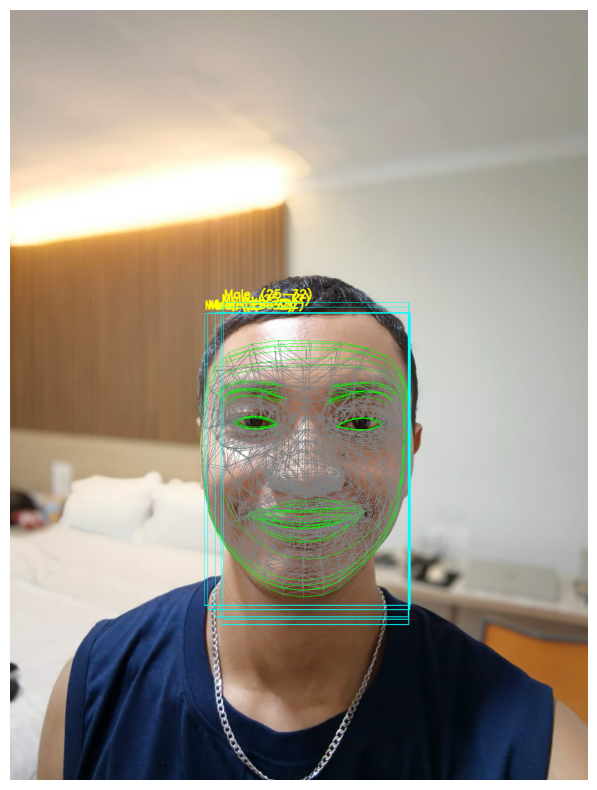

In [21]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt

# Path model (pastikan file sudah ada di folder)
face_proto = 'model/deploy.prototxt'
face_model = 'model/res10_300x300_ssd_iter_140000.caffemodel'

gender_proto = 'model/gender_deploy.prototxt'
gender_model = 'model/gender_net.caffemodel'

age_proto = 'model/age_deploy.prototxt'
age_model = 'model/age_net.caffemodel'

# Load model
face_net = cv2.dnn.readNet(face_model, face_proto)
gender_net = cv2.dnn.readNet(gender_model, gender_proto)
age_net = cv2.dnn.readNet(age_model, age_proto)

# Label
gender_list = ['Male', 'Female']
age_list = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']

# Gambar sudah tersedia pada variabel image
h, w = image.shape[:2]

# Deteksi wajah
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123], False, False)
face_net.setInput(blob)
detections = face_net.forward()

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
) as face_mesh:
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype(int)
            face_img = image[y1:y2, x1:x2].copy()
            if face_img.size == 0: 
                continue

            # Blob untuk gender & age
            blob2 = cv2.dnn.blobFromImage(face_img, 1.0, (227, 227), [104, 117, 123], swapRB=False)

            # Prediksi gender
            gender_net.setInput(blob2)
            gender_preds = gender_net.forward()
            gender = gender_list[gender_preds[0].argmax()]

            # Prediksi age
            age_net.setInput(blob2)
            age_preds = age_net.forward()
            age = age_list[age_preds[0].argmax()]

            label = f'{gender}, {age}'
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)
            cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)

            # Deteksi landmark
            face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(face_rgb)
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    mp_drawing.draw_landmarks(
                        image=face_img,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_TESSELATION,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
                    )
                    mp_drawing.draw_landmarks(
                        image=face_img,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_CONTOURS,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=1)
                    )
            image[y1:y2, x1:x2] = face_img

# Tampilkan hasil
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
